# Project: ESC-10 Classification using ESN Reservoir.

#### Author: Mohamed Hassan in  fulfillment of NN Class WS23/24

**Project Overview:**
In this undertaking, we employ the Echo State Network's dynamic reservoir of interconnected nodes to capture intricate temporal patterns present in the audio signals. The reservoir's ability to act as a dynamic memory is crucial for discerning the unique characteristics of each sound class within the dataset. The focus lies on extracting relevant features from the time domain of the audio signals to enhance classification accuracy.

**Dataset - ESC-10:**
The [ESC-10 Dataset](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/YDEPUT) comprising a variety of real-world environmental sounds, this dataset challenges the ESN to learn and generalize from diverse acoustic patterns. Each sound class within ESC-10 represents a distinct environmental context, ranging from natural sounds like rain and wind to urban and mechanical noises.




## Data preprocessing and exploration.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
import os, glob
from librosa.feature import rms, zero_crossing_rate, mfcc
from reservoirpy.nodes import Reservoir, Ridge
from tqdm import tqdm
from numpy import hanning, convolve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from cca_zoo.nonparametric import KMCCA
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns

### Importing data

In [2]:
input_dir = './dataset/ESC-10'
subdirs = os.listdir(input_dir)
subdirs.sort()
labels = []
data = []
sample_rate = 22050
for label ,folder in tqdm(enumerate(subdirs), desc='Loading data', total=len(subdirs)):
    for file in glob.glob(input_dir + '/' + folder + '/*.ogg'):
        x = librosa.load(file, sr=sample_rate)[0]
        labels.append(label)
        data.append(x)

Loading data: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


### Data Exploration 
#### Time Domain Features Visualization

 In this exploration, we focus on two fundamental time domain features: Root Mean Square (RMS) and Zero Crossing Rate (ZCR).

**Root Mean Square (RMS):**
RMS is a measure of the average magnitude of a signal, providing an indication of its overall amplitude. Mathematically, it is calculated as the square root of the mean of the squared values of the signal. For a time series, the RMS value can offer insights into the signal's energy distribution, helping to identify periods of high or low intensity.

$$\text{RMS} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} x_i^2} $$

where $ N $ is the number of data points in the time series and $ x_i $ represents each individual data point.

**Zero Crossing Rate (ZCR):**
ZCR is a measure of how often a signal changes its sign, indicating the rate at which the signal crosses the zero axis. In a time series, ZCR can highlight the frequency of changes in the signal's polarity, which may have implications for its temporal dynamics. $$ \text{ZCR} = \frac{1}{N-1} \sum_{i=1}^{N-1} \left\lvert \text{sign}(x_i) - \text{sign}(x_{i+1}) \right\rvert $$ where $ N $ is the number of data points, $ x_i $ is the i-th data point, and $ \text{sign}(\cdot) $ returns the sign of a given number.



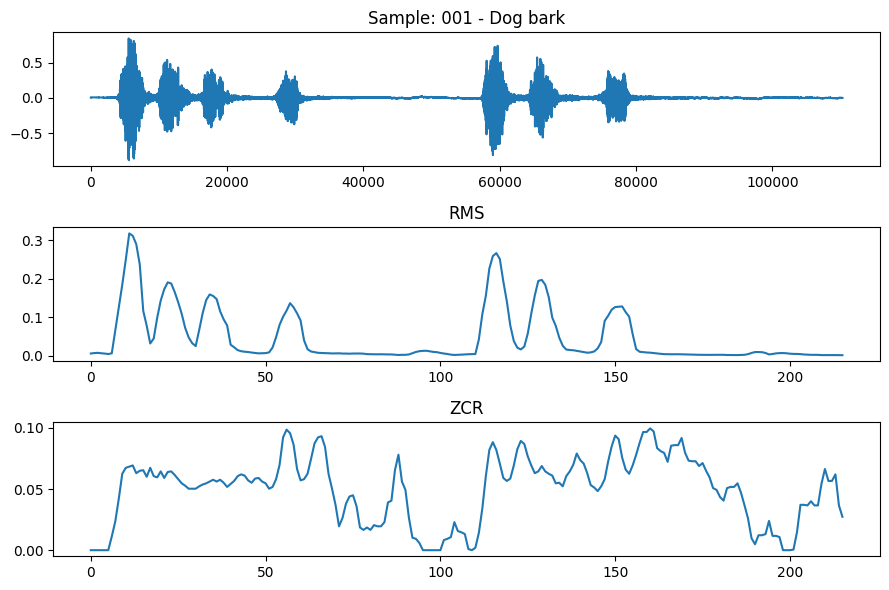

In [3]:
fig , ax = plt.subplots(nrows=3, ncols=1,figsize=(9,6))
ax[0].plot(data[10])
ax[0].set_title('Sample: ' + subdirs[labels[10]])
ax[1].plot(rms(y=data[10]).reshape(-1,1))
ax[1].set_title('RMS')
ax[2].plot(zero_crossing_rate(y=data[10]).reshape(-1,1))
ax[2].set_title('ZCR')
plt.tight_layout()
plt.show()

### Frequency Domain Features Visualization
#### MFCC (Mel Frequency Cepstral Coefficients)

In the exploration of frequency domain features, one significant component is the Mel Frequency Cepstral Coefficients (MFCC). MFCCs are coefficients representing the short-term power spectrum of a sound signal, particularly useful in audio and speech processing.

**MFCC Calculation:**
1. **Frame the Signal:**
   - The audio signal is divided into short frames to capture its spectral content over time.

2. **Apply Fourier Transform:**
   - Compute the power spectrum of each frame using the Fast Fourier Transform (FFT).

3. **Mel Filtering:**
   - Apply a set of Mel filters to the power spectrum, emphasizing certain frequency bands based on the human ear's sensitivity.

4. **Log Transformation:**
   - Take the logarithm of the filter bank energies, addressing the human ear's non-linear perception of sound intensity.

5. **Discrete Cosine Transform (DCT):**
   - Apply DCT to the log filter bank energies, resulting in the MFCCs. $$MFCC(i) = \sum_{j=1}^{M} \log(E(j)) \cdot \cos\left(\frac{\pi i j}{M}\right) $$, where $ E(j) $ represents the energy in the $ j $-th Mel filter, and $ M $ is the total number of Mel filters.



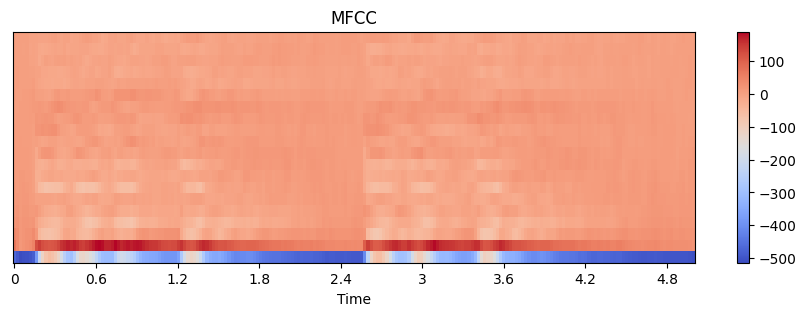

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,3))
mfccs =mfcc(y=data[10], sr=sample_rate)
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
plt.title('MFCC')
plt.show()

### Applying Window

**Purpose of Applying a Window:**
- **Mitigating Edge Effects:**
  - Windows taper the signal towards its ends, reducing the impact of discontinuities that can introduce artifacts in the frequency domain.

- **Minimizing Leakage:**
  - By gradually attenuating the signal's amplitude towards its edges, windows help to focus the spectral analysis on specific portions of the signal, minimizing interference from adjacent frequencies.

- **Unified Input Length:**
  - In order to process input of varied lengths.

**Used Window Functions:**
- **Hann Window:**
  - Defined as $$ w(n) = 0.5 - 0.5 \cos\left(\frac{2 \pi n}{N-1}\right) $$, where $ n $ is the sample index and $ N $ is the window length.


**Application Process:**

- **Multiplying the Signal:**
   - Element-wise multiplication of the signal samples with the chosen window function.

$$ x_{\text{windowed}}(n) = x(n) \cdot w(n) $$

- **Convolve the Signal:**
  - The convolution operation between two discrete signals $ x(n) $ and $ w(n) $ is mathematically expressed as:

$$ x_{\text{convolved}}(n) = \sum_{m=-\infty}^{\infty} x(m) \cdot w(n - m) $$



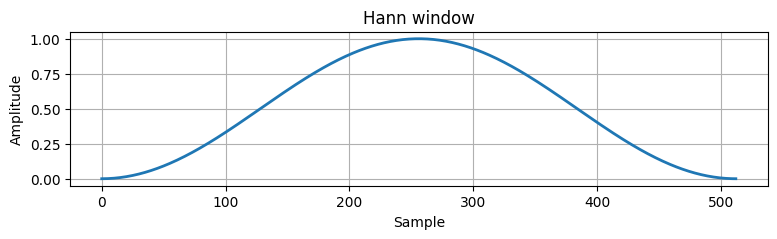

In [5]:
window = hanning(513)
plt.figure(figsize=(9,2))
plt.plot(window, label="Hann window", linewidth=2)
plt.title("Hann window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.grid()
plt.show()

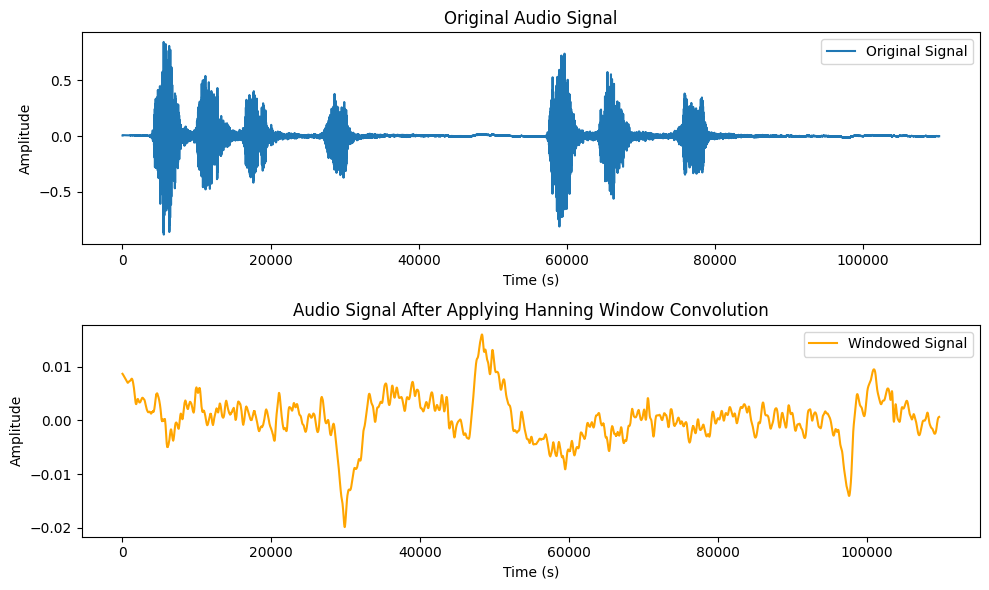

In [6]:

audio_signal = data[10]
window_size = 513
hanning_window = hanning(window_size)

windowed_signal = convolve(audio_signal, hanning_window, mode='valid') / sum(hanning_window)
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot( audio_signal, label='Original Signal')
plt.title('Original Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot( windowed_signal, label='Windowed Signal', color='orange')
plt.title('Audio Signal After Applying Hanning Window Convolution')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()


### Time Domain Windowing and Feature Extraction

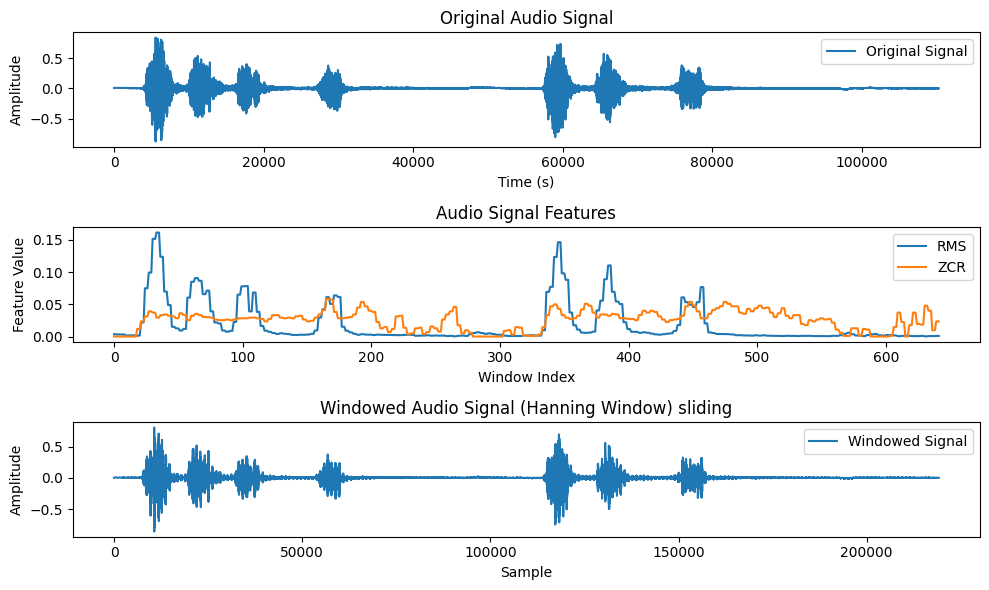

In [7]:
def apply_sliding_window(signal, window_size, overlap):
    num_samples = len(signal)
    step_size = window_size - overlap
    num_windows = int((num_samples - window_size) / step_size) + 1
    windows = np.zeros((num_windows, window_size))

    for i in range(num_windows):
        start_idx = i * step_size
        end_idx = start_idx + window_size
        windows[i, :] = signal[start_idx:end_idx] * hanning(window_size)

    return windows

def extract_audio_features(signal,label, window_size, overlap):
    windowed_signals = apply_sliding_window(signal, window_size, overlap)
    features = []
    l = []
    for window in windowed_signals:
        rms_features = np.array([rms(y=window)]).ravel()
        zcr_features = np.array([zero_crossing_rate(y=window)]).ravel()
        features.append(np.c_[rms_features, zcr_features])
        l.append(np.zeros_like(rms_features)+label)
    return np.array(features),  np.array(l)


sample_idx = 10
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(data[sample_idx], label='Original Signal')
plt.title('Original Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(extract_audio_features(data[sample_idx],labels[sample_idx] ,1024, 512)[0].reshape(-1,2), label=['RMS', 'ZCR'])
plt.title('Audio Signal Features')
plt.xlabel('Window Index')
plt.ylabel('Feature Value')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(apply_sliding_window(data[sample_idx], 1024, 512).reshape(-1), label='Windowed Signal')
plt.title('Windowed Audio Signal (Hanning Window) sliding')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
X = []
y = []
for i in range(len(data)):
    features, label = extract_audio_features(data[i],labels[i] ,1024, 512)#1024,512
    X.append(features)
    y.append(label)
X = np.concatenate(X)
y = np.concatenate(y)

print(X.shape)
print(y.shape)

def classifier_assessment(clf, X_train, y_train, X_test, y_test,title = ''):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1_score_ = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred,normalize='true')
    dpl_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test),)
    plt.figure(figsize=(8, 6))
    dpl_cm.plot(values_format='.2f', cmap='Blues',ax=plt.gca(), )
    plt.title('Confusion Matrix'+title)
    plt.show()
    print(f"Accuracy: {accuracy:.2%}")
    print(f"F1 Score: {f1_score_:.2%}")

(85727, 3, 2)
(85727, 3)


## Random Forest Classifier On Time Domain Features.

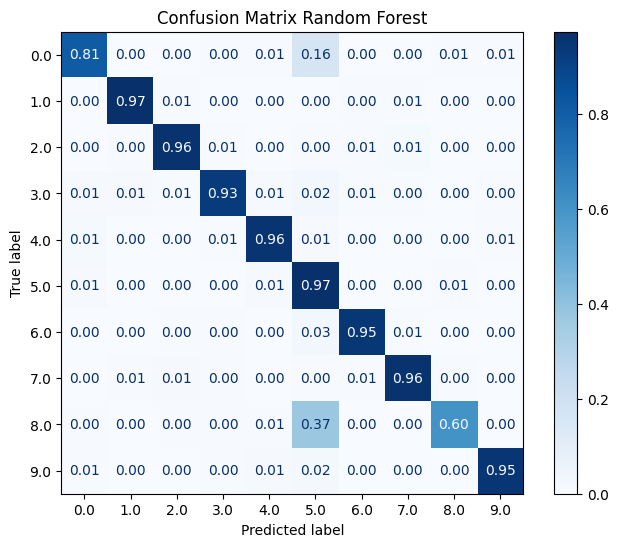

Accuracy: 90.51%
F1 Score: 90.67%


In [9]:

X = []
y = []
for i in range(len(data)):
    features, label = extract_audio_features(data[i],labels[i] ,1024, 512)#1024,512
    X.append(features)
    y.append(label)
X = np.concatenate(X)
y = np.concatenate(y)

X = X.reshape(-1, 2)  
y = y.reshape(-1, 1).flatten()  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=20, random_state=42)
classifier_assessment(clf, X_train, y_train, X_test, y_test, title=' Random Forest')

## Random Forest Classifier on Time Domain Features with Kernel Canonical Correlation Analysis (KCCA).

 **Maximizing Correlation:** The main objective of KCCA is to find linear combinations of variables in each dataset, referred to as canonical variables, that maximize the correlation between them in the transformed space. This is particularly useful when dealing with complex, non-linear dependencies between datasets, making KCCA valuable in various applications, including machine learning, bioinformatics, and pattern recognition.
The key steps for Kernel CCA include:

1. **Kernelization:** Apply a kernel function to the input data of both sets, mapping them into a higher-dimensional space.

2. **Centering:** Center the kernel matrices to ensure zero mean in the transformed space.

3. **Eigenvalue Decomposition:** Perform eigenvalue decomposition on the cross-covariance matrix of the transformed data.

4. **Canonical Variables:** The eigenvectors corresponding to the largest eigenvalues give the canonical variables, representing linear combinations of variables in the transformed space.

**Note:**
- Varying the standard deviation for the Gaussian kernel or adjusting the window size did not have a significant impact on performance.

(257181, 2)
(257181,)


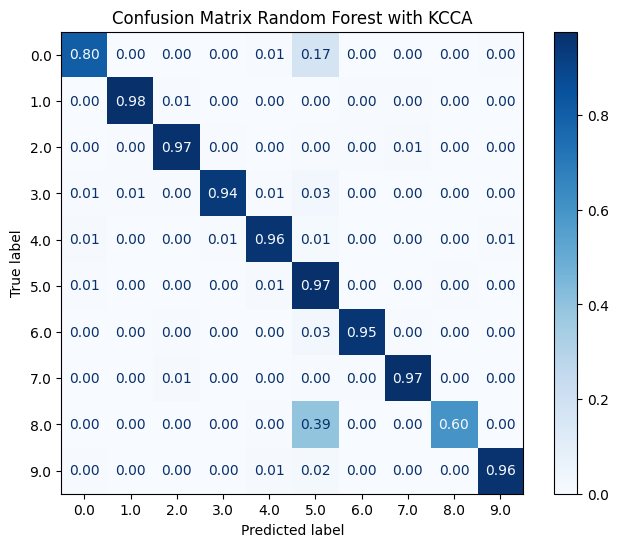

Accuracy: 91.00%
F1 Score: 91.20%


In [10]:

X = []
y = []
for i in range(len(data)):
    features, label = extract_audio_features(data[i],labels[i] ,1024, 512) #1024,512
    X.append(features)
    y.append(label)
X = np.concatenate(X)
y = np.concatenate(y)

X_kcca = []
for i in range(len(X)):
    sigma = np.std(X[i])# =1
    kernel = lambda x: np.exp(-x ** 2 / (2. * sigma ** 2))
    model = KMCCA(kernel==kernel)
    shape = X[i].shape
    xi = X[i].reshape(shape[0],shape[1],1)
    model.fit(xi)
    X_kcca.append(model.transform(xi))



X = np.array(X_kcca).reshape(-1, 2)  
print(X.shape)
y = y.reshape(-1, 1).flatten()  
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
classifier_assessment(clf, X_train, y_train, X_test, y_test, title=' Random Forest with KCCA')

## ESN Reservoir on Time Domain Features.


**Echo State Network (ESN):** ESN is a type of recurrent neural network (RNN) characterized by a dynamic reservoir of interconnected nodes. In the context of time domain features, an ESN reservoir processes sequential data, leveraging its recurrent connections to capture temporal dependencies. The reservoir acts as a dynamic memory that can efficiently handle time series data.


**Ridge:**
   - Refers to ridge regression.
   - Ridge regression is a regularization technique that is applied during the training of the readout layer in ESNs.
   - It helps prevent overfitting by adding a penalty term to the linear regression problem, promoting more stable and generalizable solutions.

**Readout:**
   - The "readout" in an ESN refers to the output layer of the network.
   - The readout layer transforms the dynamic reservoir states into the final output.
   - It is a crucial component responsible for mapping the learned temporal dependencies in the reservoir to the desired output of the network, typically using techniques like ridge regression during training.


In [11]:
%%capture 

X = []
y = []
for i in range(len(data)):
    features, label = extract_audio_features(data[i],labels[i] ,1024, 512)#1024,512
    reservoir = Reservoir(units=100, lr=0.3, sr=1.25)
    readout = Ridge(output_dim=2, ridge=1e-5)
    esn = reservoir >> readout
    features = features.reshape(-1,2)
    predictions = esn.fit(features[:20], features[1:21]).run(features[0:-1]); 
    X.append(predictions)
    label = np.zeros_like(predictions[:,0])+labels[i]
    y.append(label)
X = np.concatenate(X)
y = np.concatenate(y)
print(X.shape)
print(y.flatten().shape)

## Random Forest Classifier On Time Domain Features and Reservoir.

(256781, 2)
(256781,)


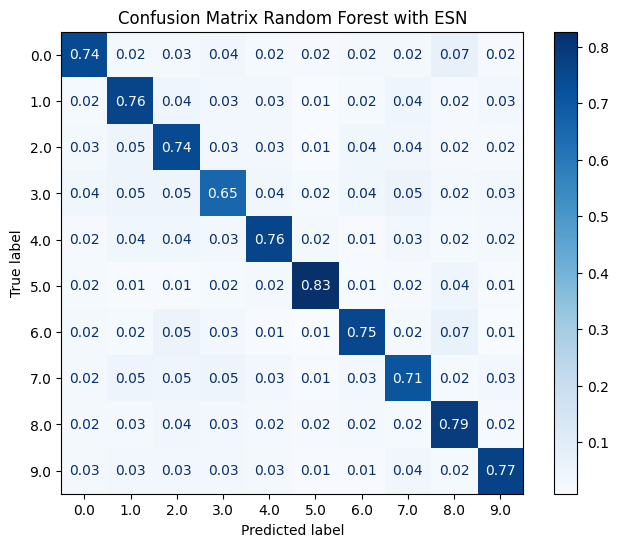

Accuracy: 74.99%
F1 Score: 75.02%


In [12]:

from sklearn.cross_decomposition import CCA
from cca_zoo.nonparametric import KMCCA

print(X.shape)
y = y.reshape(-1, 1).flatten() 
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=25, random_state=42)
classifier_assessment(clf, X_train, y_train, X_test, y_test, title=' Random Forest with ESN')

## Random Forest Classifier On Time Domain Features with Reservoir and KCCA . 

In [14]:
%%capture

X = []
y = []
for i in range(len(data)):
    features, label = extract_audio_features(data[i],labels[i] ,1024, 512)   #1024,512
    reservoir = Reservoir(units=100, lr=0.3, sr=1.25);
    readout = Ridge(output_dim=2, ridge=1e-5);
    esn = reservoir >> readout
    features = features.reshape(-1,2)
    #print(features.shape)
    predictions = esn.fit(features[:-2], features[1:-1]).run(features[0:-1]);
    #print(predictions.shape)
    #print(label.shape)
    sigma =1
    kernel = lambda x: np.exp(-x ** 2 / (2. * sigma ** 2))
    model = KMCCA(kernel==kernel)
    shape = predictions.shape
    model.fit(predictions.reshape(shape[0],shape[1],1))
    kcca = model.transform(predictions.reshape(shape[0],shape[1],1))
    kcca = np.array(kcca)
    X.append(kcca.reshape(-1,2))
    label = np.zeros((kcca.shape[0],1))+labels[i]
    y.append(label)
    print(kcca.shape)
    print(label.shape)
X = np.concatenate(X)
y = np.concatenate(y)

(256781, 2)
(256781,)


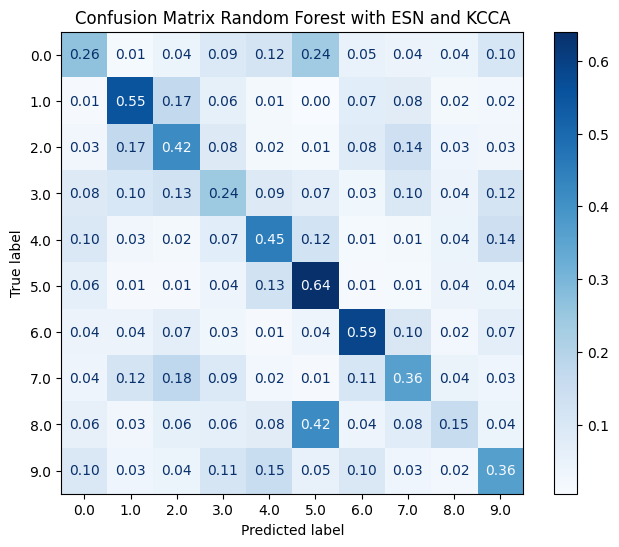

Accuracy: 40.33%
F1 Score: 39.21%


In [20]:

print(X.shape)
y = y.reshape(-1, 1).flatten()  
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=30, random_state=42)
classifier_assessment(clf, X_train, y_train, X_test, y_test, title=' Random Forest with ESN and KCCA')

## Support Vector Machine Classifier On Time Domain Features.

(85727, 3, 2)
(85727, 3)


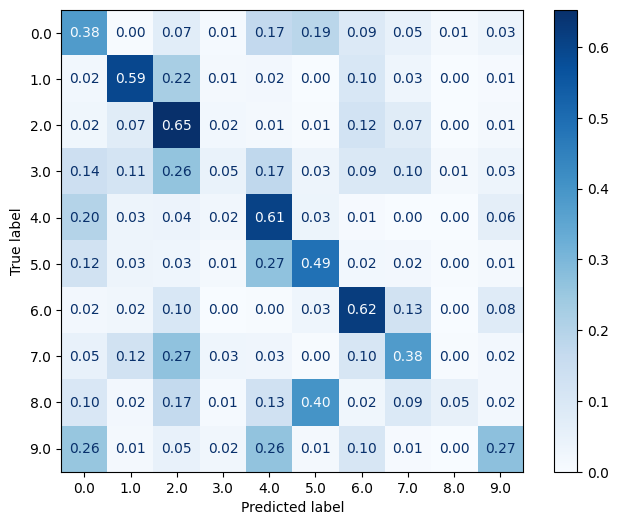

Accuracy: 40.96%
F1 Score: 37.58%


In [ ]:
X = []
y = []
for i in range(len(data)):
    features, label = extract_audio_features(data[i],labels[i] ,1024, 512)#1024,512
    X.append(features)
    y.append(label)
X = np.concatenate(X)
y = np.concatenate(y)

print(X.shape)
print(y.shape)

X = X.reshape(-1, 2)  
y = y.reshape(-1, 1).flatten()  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC(kernel='rbf', C=1.0, random_state=42)
classifier_assessment(clf, X_train, y_train, X_test, y_test, title=' SVM')

## Support Vector Machine  On Time Domain Features with Reservoir and KCCA . 

(257181, 2)
(257181,)


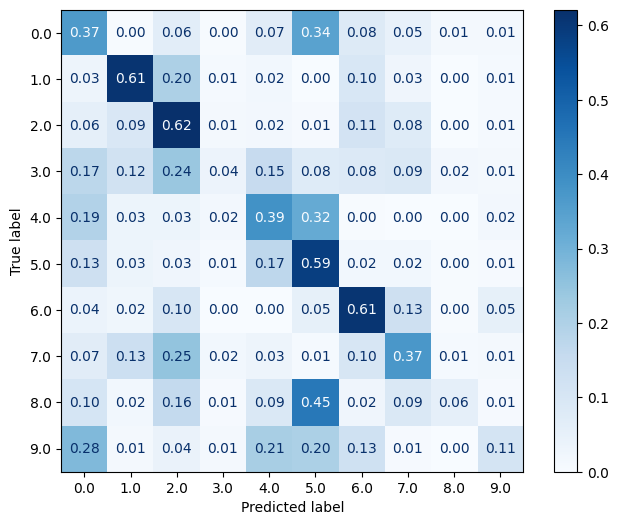

Accuracy: 37.56%
F1 Score: 33.79%


In [ ]:
X = []
y = []
for i in range(len(data)):
    features, label = extract_audio_features(data[i],labels[i] ,1024, 512)#1024,512
    X.append(features)
    y.append(label)
X = np.concatenate(X)
y = np.concatenate(y)

# print(X.shape)
# print(y.shape)

X_kcca = []
for i in range(len(X)):
    sigma = np.std(X[i])# =1
    kernel = lambda x: np.exp(-x ** 2 / (2. * sigma ** 2))
    model = KMCCA(kernel==kernel)
    shape = X[i].shape
    model.fit(X[i].reshape(shape[0],shape[1],1))
    X_kcca.append(model.transform(X[i].reshape(shape[0],shape[1],1)))
    
X = np.array(X_kcca).reshape(-1, 2)  
print(X.shape)
y = y.reshape(-1, 1).flatten()  
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
clf = svm.SVC(kernel='rbf', C=1.0, random_state=42)
classifier_assessment(clf, X_train, y_train, X_test, y_test, title=' SVM with KCCA')

## Observations and Conclusion

### Observations:

- The method exhibited sensitivity to the choice of window size.
- Superior results were achieved when applying the window using a multiplication approach rather than convolution.
- In general, the Random Forest Classifier outperformed the Support Vector Machine.
- The application of Canonical Correlation Analysis (CCA) and Kernel Canonical Correlation Analysis (KCCA) resulted in a degradation in performance.
- Certain hyperparameters, such as the kernel choice for SVM, had a substantial impact on both training time and accuracy.
- Changing the number of estimators for Random Forest did not yield significant effects.

### Conclusion:

- Depending on the nature of the problem and the features involved, a simple solution may prove more effective than a complex one.
- It is better to start with a simple straightforward solution, evaluate its performance, and subsequently iterate towards improvement.